In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import wave,os,librosa,tqdm,time,warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [3]:
def preprocess_split_train_test(df,model,name,apply_smote=False,rs=536,printres=True,returnModelFiles=False,apply_LDA=True,onlypreprocess=False,hppms=None):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  print("Train test split done")
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  print("Scaling done")
  if apply_LDA:
    lda = LinearDiscriminantAnalysis()
    trainX = lda.fit_transform(trainX, trainY)
    testX = lda.transform(testX)
    print("LDA Tranformation Done")
  le = LabelEncoder()
  y2 = le.fit_transform(y)
  if name=='XGBoost':
    trainY, testY = le.transform(trainY), le.transform(testY)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
    print("SMOTE done")
  if onlypreprocess:
    return trainX,trainY,testX,testY
  print("Training model started")
  model.fit(trainX, trainY)
  print("Training model done")
  predictions = le.inverse_transform(model.predict(testX))
  testY = le.inverse_transform(testY)
  acc = accuracy_score(testY, predictions)
  if printres:
    plot_confusion_matrix(testY, predictions,le.classes_)
    print(f"\n{name} Accuracy: {acc*100:.3f}%")
    print(classification_report(testY, predictions))
  if returnModelFiles:
    return model,scaler,acc
  if hppms:
    return acc,hppms
  return acc

def plot_confusion_matrix(y_true, y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

In [4]:
iem = pd.read_csv('/kaggle/input/iemocap-opensmile-features-wo-nr-and-trim/IEMOCAP_OpenSMILE_Features_2.csv')
iem.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,1.926013,0.277273,0.918182,0.191417,0.268062,0.340347,0.076645,0.072285,0.148930,0.116788,...,0.394074,2.275440,2.182265,15.265785,0.614398,121.792305,51.254950,82.042160,37.047375,happy
1,5.685206,0.140230,0.475862,0.639400,1.104511,2.018396,0.465112,0.913885,1.378997,0.147730,...,0.455433,2.428989,2.520563,-15.630270,0.616582,112.319760,64.743660,104.517380,64.524280,happy
2,4.983028,0.475664,0.332965,0.409132,0.786660,1.280687,0.377528,0.494027,0.871555,0.122453,...,0.517633,2.988111,2.982978,19.997930,0.477680,115.317444,64.748505,120.824974,86.938000,happy
3,2.402391,0.093151,0.447945,0.304826,0.515305,0.917745,0.210479,0.402439,0.612918,0.108701,...,0.709114,2.328720,2.334292,-19.990845,0.416661,104.577990,46.277046,105.559364,50.838806,happy
4,2.895896,0.696078,0.992157,0.463905,0.996315,1.357507,0.532410,0.361192,0.893602,0.135243,...,0.470490,2.833275,2.828998,19.998919,0.518914,116.583115,69.316536,117.198210,60.027150,happy


In [5]:
iem.label.value_counts()

label
frustrated    1849
neutral       1708
happy         1636
angry         1103
sad           1084
surprised      107
fear            40
disgust          2
Name: count, dtype: int64

In [6]:
iem = iem[iem['label'].isin(['neutral','happy','sad','angry'])]
iem.label.value_counts()

label
neutral    1708
happy      1636
angry      1103
sad        1084
Name: count, dtype: int64

Train test split done
Scaling done
Training model started
Training model done


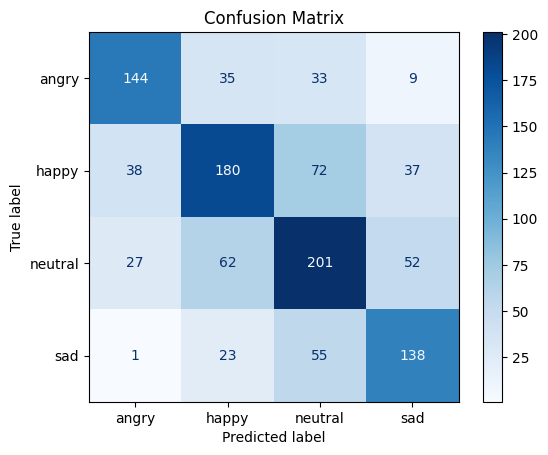


Logistic Regression Accuracy: 59.892%
              precision    recall  f1-score   support

       angry       0.69      0.65      0.67       221
       happy       0.60      0.55      0.57       327
     neutral       0.56      0.59      0.57       342
         sad       0.58      0.64      0.61       217

    accuracy                           0.60      1107
   macro avg       0.61      0.61      0.61      1107
weighted avg       0.60      0.60      0.60      1107

CPU times: user 6min 8s, sys: 1min 9s, total: 7min 18s
Wall time: 1min 54s


In [7]:
%%time
lr_model = LogisticRegression(C=0.3,class_weight='balanced',max_iter=1000)
acc_lr = preprocess_split_train_test(iem,lr_model,'Logistic Regression',rs=536,apply_LDA=False)

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


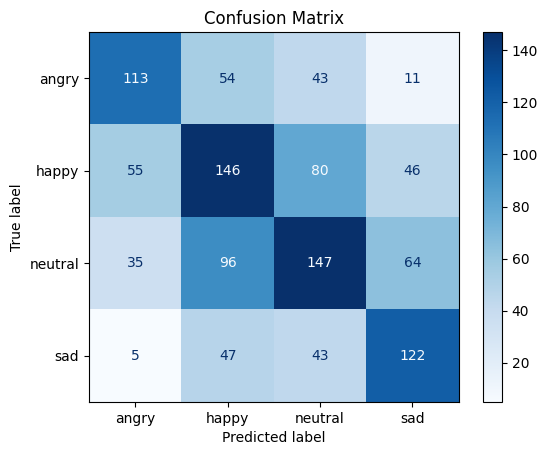


Decision Tree Accuracy: 47.696%
              precision    recall  f1-score   support

       angry       0.54      0.51      0.53       221
       happy       0.43      0.45      0.44       327
     neutral       0.47      0.43      0.45       342
         sad       0.50      0.56      0.53       217

    accuracy                           0.48      1107
   macro avg       0.49      0.49      0.49      1107
weighted avg       0.48      0.48      0.48      1107

CPU times: user 1min 21s, sys: 508 ms, total: 1min 22s
Wall time: 1min 20s


In [10]:
%%time
dt_model = DecisionTreeClassifier(criterion='entropy',random_state=100)
acc_dt = preprocess_split_train_test(iem,dt_model,'Decision Tree',rs=536,apply_LDA=False,apply_smote=True)

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


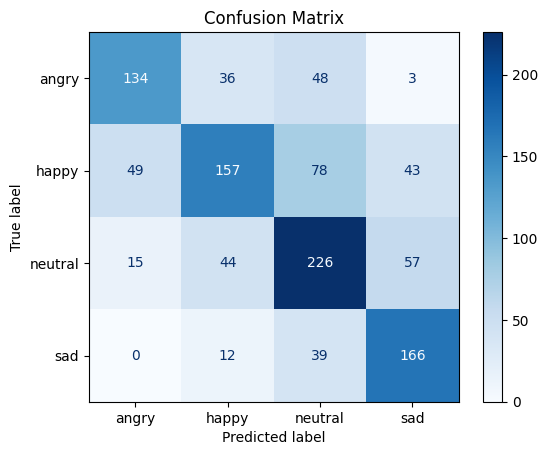


Random Forest Accuracy: 61.698%
              precision    recall  f1-score   support

       angry       0.68      0.61      0.64       221
       happy       0.63      0.48      0.55       327
     neutral       0.58      0.66      0.62       342
         sad       0.62      0.76      0.68       217

    accuracy                           0.62      1107
   macro avg       0.63      0.63      0.62      1107
weighted avg       0.62      0.62      0.61      1107

CPU times: user 1min 6s, sys: 473 ms, total: 1min 6s
Wall time: 1min 4s


In [11]:
%%time
rf_model = RandomForestClassifier(n_estimators=150,random_state=20)
acc_rf = preprocess_split_train_test(iem,rf_model,'Random Forest',rs=536,apply_LDA=False,apply_smote=True)

Train test split done
Scaling done
Training model started
Training model done


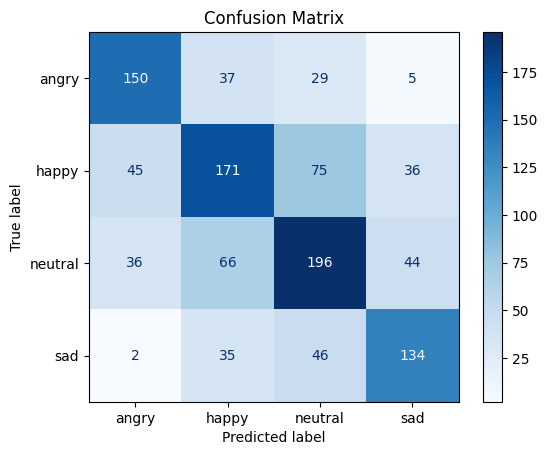


SVM Accuracy: 58.808%
              precision    recall  f1-score   support

       angry       0.64      0.68      0.66       221
       happy       0.55      0.52      0.54       327
     neutral       0.57      0.57      0.57       342
         sad       0.61      0.62      0.61       217

    accuracy                           0.59      1107
   macro avg       0.59      0.60      0.60      1107
weighted avg       0.59      0.59      0.59      1107

CPU times: user 1min 18s, sys: 443 ms, total: 1min 18s
Wall time: 1min 18s


In [12]:
%%time
svm_model = SVC(kernel='linear')
acc_svm = preprocess_split_train_test(iem,svm_model,'SVM',rs=536,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


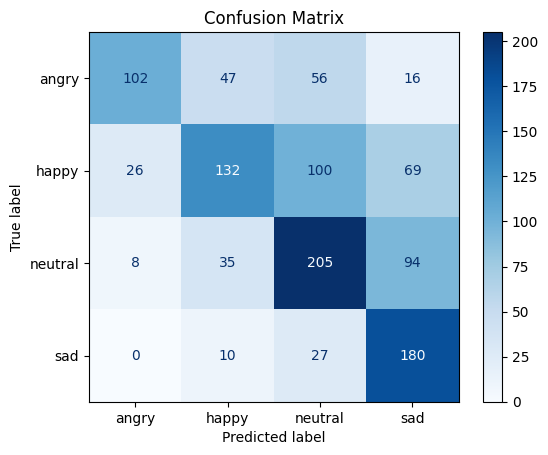


KNN Accuracy: 55.917%
              precision    recall  f1-score   support

       angry       0.75      0.46      0.57       221
       happy       0.59      0.40      0.48       327
     neutral       0.53      0.60      0.56       342
         sad       0.50      0.83      0.62       217

    accuracy                           0.56      1107
   macro avg       0.59      0.57      0.56      1107
weighted avg       0.59      0.56      0.55      1107

CPU times: user 4.05 s, sys: 373 ms, total: 4.43 s
Wall time: 2.16 s


In [13]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=13)
acc_knn = preprocess_split_train_test(iem,knn_model,'KNN',rs=536,apply_LDA=False)

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


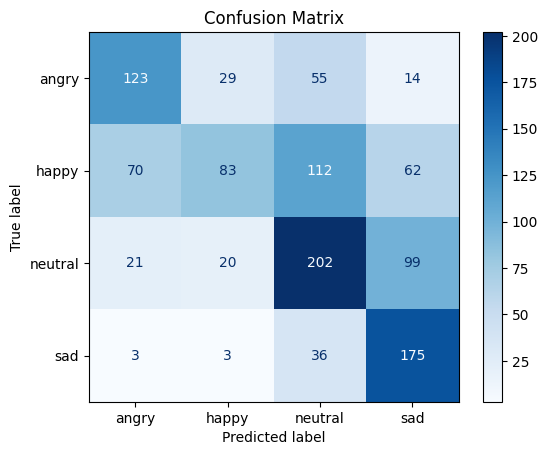


Naive Bayes Accuracy: 52.665%
              precision    recall  f1-score   support

       angry       0.57      0.56      0.56       221
       happy       0.61      0.25      0.36       327
     neutral       0.50      0.59      0.54       342
         sad       0.50      0.81      0.62       217

    accuracy                           0.53      1107
   macro avg       0.55      0.55      0.52      1107
weighted avg       0.55      0.53      0.51      1107

CPU times: user 4.07 s, sys: 550 ms, total: 4.62 s
Wall time: 2.82 s


In [14]:
%%time
nb_model = GaussianNB()
acc_nb = preprocess_split_train_test(iem,nb_model,'Naive Bayes',rs=536,apply_LDA=False,apply_smote=True)

Train test split done
Scaling done
Training model started
Training model done


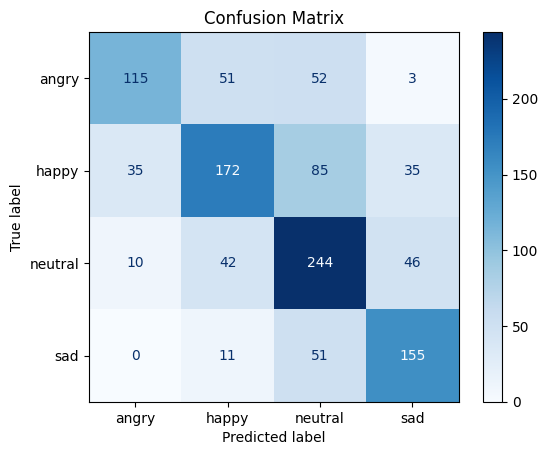


AdaBoost Accuracy: 61.969%
              precision    recall  f1-score   support

       angry       0.72      0.52      0.60       221
       happy       0.62      0.53      0.57       327
     neutral       0.56      0.71      0.63       342
         sad       0.65      0.71      0.68       217

    accuracy                           0.62      1107
   macro avg       0.64      0.62      0.62      1107
weighted avg       0.63      0.62      0.62      1107

CPU times: user 44.9 s, sys: 390 ms, total: 45.3 s
Wall time: 45 s


In [15]:
%%time
ab_model = AdaBoostClassifier(estimator=rf_model,algorithm='SAMME')
acc_ab = preprocess_split_train_test(iem,ab_model,'AdaBoost',rs=536,apply_LDA=False)

Train test split done
Scaling done
Training model started
Training model done


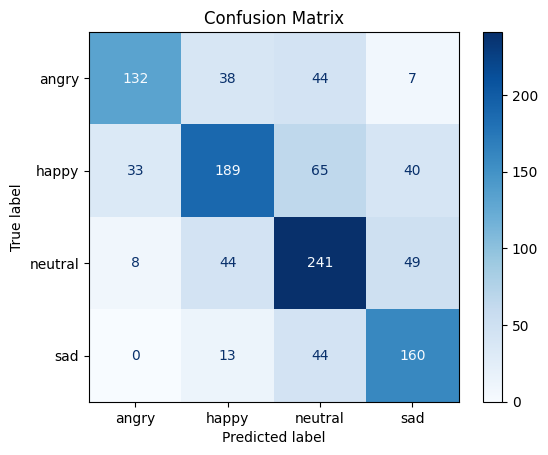


XGBoost Accuracy: 65.221%
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       221
           1       0.67      0.58      0.62       327
           2       0.61      0.70      0.65       342
           3       0.62      0.74      0.68       217

    accuracy                           0.65      1107
   macro avg       0.67      0.65      0.66      1107
weighted avg       0.66      0.65      0.65      1107

CPU times: user 54.1 s, sys: 958 ms, total: 55.1 s
Wall time: 45.3 s


In [34]:
%%time
xgb_model = XGBClassifier(random_state=42,device='cuda')
acc_xgb = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=536,apply_LDA=False)

In [13]:
from scipy.stats import randint, uniform
hpr = []
iters = 10
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Training Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(iem,xgb_model,'XGBoost',apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")

Iter No. - 0
Model Params = {'learning_rate': 0.06426559713413688, 'n_estimators': 197, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.8550051655810883, 'subsample': 0.7390792338911341, 'colsample_bytree': 0.6421114975318519, 'reg_alpha': 0.9234944355887919, 'reg_lambda': 0.5226635275331226, 'scale_pos_weight': 8.456546850050522, 'random_state': 417}
Training Params = {'apply_smote': True, 'rs': 867}

Train test split done
Scaling done
SMOTE done
Training model started
Training model done
Time taken = 1 min 15 sec

Current Accuracy = 65.94%
Best Accuracy = 65.94%
Best Params Found so far = {'learning_rate': 0.06426559713413688, 'n_estimators': 197, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.8550051655810883, 'subsample': 0.7390792338911341, 'colsample_bytree': 0.6421114975318519, 'reg_alpha': 0.9234944355887919, 'reg_lambda': 0.5226635275331226, 'scale_pos_weight': 8.456546850050522, 'random_state': 417, 'apply_smote': True, 'rs': 867}

Iter No. - 1
Model Params = {'learning_

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


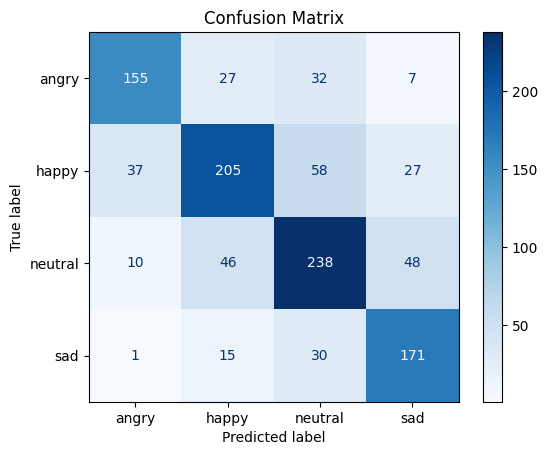


XGBoost Accuracy: 69.467%
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       221
           1       0.70      0.63      0.66       327
           2       0.66      0.70      0.68       342
           3       0.68      0.79      0.73       217

    accuracy                           0.69      1107
   macro avg       0.70      0.70      0.70      1107
weighted avg       0.70      0.69      0.69      1107



In [14]:
mparams = {'learning_rate': 0.31764176383513953, 'n_estimators': 99, 'max_depth': 17,
           'min_child_weight': 6, 'gamma': 0.6888761603845618, 'subsample': 0.8512773442442418,
           'colsample_bytree': 0.6311542245639549, 'reg_alpha': 0.5479410121403062, 'reg_lambda': 0.9104899442474191,
           'scale_pos_weight': 7.1753378652063144, 'random_state': 840}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_smote=True,apply_LDA=False)

In [8]:
from scipy.stats import randint, uniform
hpr = []
iters = 20
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        #'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Training Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'learning_rate': 0.4474157740671015, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.6349389803297405, 'subsample': 0.3003266893576226, 'colsample_bytree': 0.7948902977760144, 'reg_alpha': 0.5956421262375943, 'reg_lambda': 0.46365631777660843, 'scale_pos_weight': 10.41050252869074, 'random_state': 459}
Training Params = {'apply_smote': False}

Train test split done
Scaling done
Training model started
Training model done
Time taken = 0 min 11 sec

Current Accuracy = 61.61%
Best Accuracy = 61.61%
Best Params Found so far = {'learning_rate': 0.4474157740671015, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 0.6349389803297405, 'subsample': 0.3003266893576226, 'colsample_bytree': 0.7948902977760144, 'reg_alpha': 0.5956421262375943, 'reg_lambda': 0.46365631777660843, 'scale_pos_weight': 10.41050252869074, 'random_state': 459, 'apply_smote': False}

Iter No. - 1
Model Params = {'learning_rate': 0.48492036124351007, 'n_

Train test split done
Scaling done
SMOTE done
Training model started
Training model done


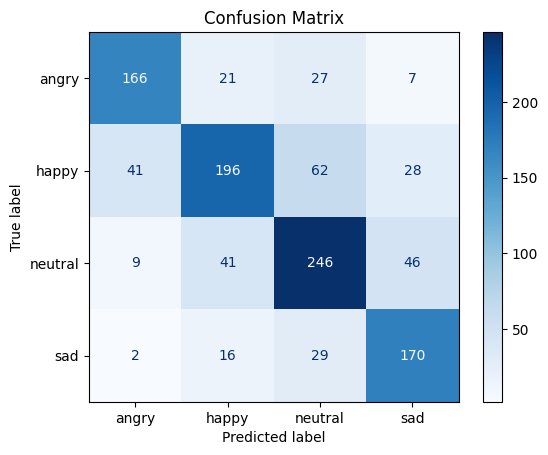


XGBoost Accuracy: 70.280%
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       221
           1       0.72      0.60      0.65       327
           2       0.68      0.72      0.70       342
           3       0.68      0.78      0.73       217

    accuracy                           0.70      1107
   macro avg       0.71      0.71      0.71      1107
weighted avg       0.70      0.70      0.70      1107



In [10]:
mparams = {'learning_rate': 0.15293972301876466, 'n_estimators': 171, 'max_depth': 5,
           'min_child_weight': 9, 'gamma': 0.45413454499809414, 'subsample': 0.8212696656313125,
           'colsample_bytree': 0.9865880366147188, 'reg_alpha': 0.6940634692230532, 'reg_lambda': 0.5465318311389699,
           'scale_pos_weight': 10.147051559243675, 'random_state': 542}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_smote=True,apply_LDA=False)

In [11]:
from scipy.stats import randint, uniform
hpr = []
iters = 20
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        #'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Training Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'learning_rate': 0.012400330173187589, 'n_estimators': 196, 'max_depth': 18, 'min_child_weight': 8, 'gamma': 0.5203404394551364, 'subsample': 0.9699746659586421, 'colsample_bytree': 0.7808477350923189, 'reg_alpha': 0.4901994462149073, 'reg_lambda': 0.47418321296282906, 'scale_pos_weight': 10.713848440586197, 'random_state': 117}
Training Params = {'apply_smote': True}

Train test split done
Scaling done
SMOTE done
Training model started
Training model done
Time taken = 4 min 17 sec

Current Accuracy = 66.12%
Best Accuracy = 66.12%
Best Params Found so far = {'learning_rate': 0.012400330173187589, 'n_estimators': 196, 'max_depth': 18, 'min_child_weight': 8, 'gamma': 0.5203404394551364, 'subsample': 0.9699746659586421, 'colsample_bytree': 0.7808477350923189, 'reg_alpha': 0.4901994462149073, 'reg_lambda': 0.47418321296282906, 'scale_pos_weight': 10.713848440586197, 'random_state': 117, 'apply_smote': True}

Iter No. - 1
Model Params = {'learning_rate': 0.23267

Train test split done
Scaling done
Training model started
Training model done


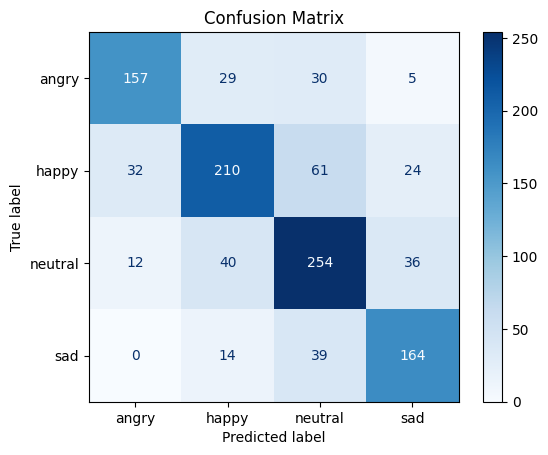


XGBoost Accuracy: 70.912%
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       221
           1       0.72      0.64      0.68       327
           2       0.66      0.74      0.70       342
           3       0.72      0.76      0.74       217

    accuracy                           0.71      1107
   macro avg       0.72      0.71      0.71      1107
weighted avg       0.71      0.71      0.71      1107



In [12]:
mparams = {'learning_rate': 0.10719074355505309, 'n_estimators': 137, 'max_depth': 15,
           'min_child_weight': 6, 'gamma': 0.3468473686008403, 'subsample': 0.6766500869773895,
           'colsample_bytree': 0.9386009445047017, 'reg_alpha': 0.7974399590457204, 'reg_lambda': 0.6648795329325674,
           'scale_pos_weight': 6.5828329701474155, 'random_state': 785}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False)

In [13]:
from scipy.stats import randint, uniform
hpr = []
iters = 20
max_acc = 0
best_params = dict()
st = time.time()
param_grid = {
        'learning_rate': uniform(0.01, 0.5-0.01),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.3, 1-0.3),
    'colsample_bytree': uniform(0.5, 1-0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': uniform(1, 15-1),
    'random_state':randint(0,1000)
          }
params2 = {
        'apply_smote':[False,True],
        #'rs': [i for i in range(0,1000)]
    }
for k in range(iters):
    chosen_params = {param: dist.rvs() for param, dist in param_grid.items()}
    xgb_model = XGBClassifier(device='cuda',**chosen_params)
    chosen_params2 = {param: np.random.choice(values) for param, values in params2.items()}
    print(f"Iter No. - {k}")
    print(f"Model Params = {chosen_params}")
    print(f"Training Params = {chosen_params2}\n")
    acc_xgb,(chosen_params,chosen_params2) = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False,printres=False,**chosen_params2,hppms=(chosen_params,chosen_params2))
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    chosen_params.update(chosen_params2)
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = chosen_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'learning_rate': 0.12594472802703188, 'n_estimators': 114, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.6082290476430463, 'subsample': 0.6728997875232355, 'colsample_bytree': 0.6721364920110072, 'reg_alpha': 0.6485783132237801, 'reg_lambda': 0.14827306310656485, 'scale_pos_weight': 9.167608744457159, 'random_state': 758}
Training Params = {'apply_smote': False}

Train test split done
Scaling done
Training model started
Training model done
Time taken = 0 min 48 sec

Current Accuracy = 68.74%
Best Accuracy = 68.74%
Best Params Found so far = {'learning_rate': 0.12594472802703188, 'n_estimators': 114, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.6082290476430463, 'subsample': 0.6728997875232355, 'colsample_bytree': 0.6721364920110072, 'reg_alpha': 0.6485783132237801, 'reg_lambda': 0.14827306310656485, 'scale_pos_weight': 9.167608744457159, 'random_state': 758, 'apply_smote': False}

Iter No. - 1
Model Params = {'learning_rate': 0.0874847343188202, 

Train test split done
Scaling done
Training model started
Training model done


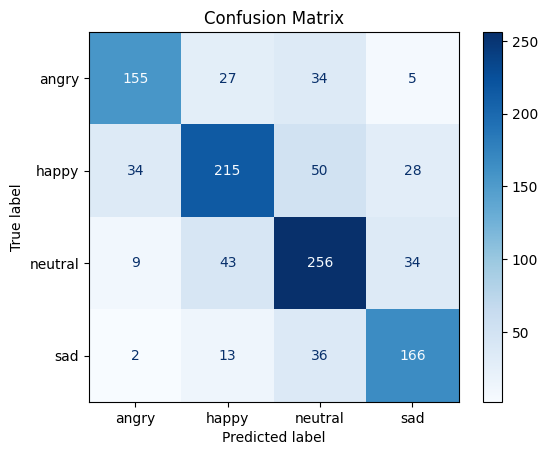


XGBoost Accuracy: 71.545%
              precision    recall  f1-score   support

       angry       0.78      0.70      0.74       221
       happy       0.72      0.66      0.69       327
     neutral       0.68      0.75      0.71       342
         sad       0.71      0.76      0.74       217

    accuracy                           0.72      1107
   macro avg       0.72      0.72      0.72      1107
weighted avg       0.72      0.72      0.72      1107



In [20]:
mparams = {'learning_rate': 0.2562237554891413, 'n_estimators': 199, 'max_depth': 8,
           'min_child_weight': 5, 'gamma': 0.06186888261825085, 'subsample': 0.9877907683868481,
           'colsample_bytree': 0.8993963240419367, 'reg_alpha': 0.6774674241008479, 'reg_lambda': 0.6257742179930207,
           'scale_pos_weight': 2.286635765363375, 'random_state': 445}
xgb_model = XGBClassifier(device='cuda',**mparams)
acc_xgb = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False)

In [11]:
hpr = []
iters = 20
max_acc = 0
best_params = dict()
st = time.time()
for k in range(iters):
    model_params = {
        'learning_rate': np.random.uniform(0.1, 0.4),
    'n_estimators': np.random.randint(150, 250),
    'max_depth': np.random.randint(5, 10),
    'min_child_weight': np.random.randint(3, 7),
    'gamma': np.random.uniform(0, 0.1),
    'subsample': np.random.uniform(0.9, 1),
    'colsample_bytree': np.random.uniform(0.8, 1),
    'reg_alpha': np.random.uniform(0.5, 0.8),
    'reg_lambda': np.random.uniform(0.5, 0.8),
    'scale_pos_weight': np.random.uniform(1, 4),
    'random_state':445
          }
    xgb_model = XGBClassifier(device='cuda',**model_params)
    print(f"Iter No. - {k}")
    print(f"Model Params = {model_params}")
    acc_xgb,model_params = preprocess_split_train_test(iem,xgb_model,'XGBoost',rs=86,apply_LDA=False,printres=False,hppms=model_params)
    en = time.time()
    tm = en-st
    print(f"Time taken = {int(tm/60)} min {int(tm%60)} sec")
    if acc_xgb>max_acc:
        max_acc = acc_xgb
        best_params = model_params
    print(f"\nCurrent Accuracy = {acc_xgb*100:.2f}%")
    print(f"Best Accuracy = {max_acc*100:.2f}%")
    print(f"Best Params Found so far = {best_params}\n")
print("Hyperparameter Tuning Done!")

Iter No. - 0
Model Params = {'learning_rate': 0.13158228047248635, 'n_estimators': 233, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.02871038810974548, 'subsample': 0.9776324655914914, 'colsample_bytree': 0.8693218138774252, 'reg_alpha': 0.6273419589949977, 'reg_lambda': 0.5422047165670412, 'scale_pos_weight': 2.4109531823392967, 'random_state': 445}
Train test split done
Scaling done
Training model started
Training model done
Time taken = 1 min 7 sec

Current Accuracy = 71.54%
Best Accuracy = 71.54%
Best Params Found so far = {'learning_rate': 0.13158228047248635, 'n_estimators': 233, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.02871038810974548, 'subsample': 0.9776324655914914, 'colsample_bytree': 0.8693218138774252, 'reg_alpha': 0.6273419589949977, 'reg_lambda': 0.5422047165670412, 'scale_pos_weight': 2.4109531823392967, 'random_state': 445}

Iter No. - 1
Model Params = {'learning_rate': 0.10460186729865927, 'n_estimators': 153, 'max_depth': 6, 'min_child_weight': 3, 'gam